---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

## Introduction
In this stage, I will be using supervising learning techniques for regressinon, binary classification and multi-class classification tasks. 
My goal is to be able to answer the following research questions:

1. Can we predict whether an individual has shopped online based on their demographic and financial information in the past year?
2. Can we predict one's online shopping expenditure based on their annual earnings and expenses?
3. Can we predict one's sex based on their demographics and financial information?
4. Can we predict one's education level based on demographic and financial information?


## Overview of Methods
In this stage, I will begin by doing feature selection, correlation tests for Regression and Chi Squared tests for the Classification sections. After that I will split the data into train and test portions with a 80:20 ratio. Then, I will be doing some resampling either using SMOTE or balancing class weights, and also model tuning with GridSearchCV to find the best model parameters.

For Regression, I will implement Lasso, Elastic Net, Random Forest Regressor, XGBoost, and Decision Tree Regressor. Their performances will be compared and evaluated on their RMSE, MAE and R-squared values.
For Binary and Multi-Class Classification, I will implement Logistic Regression, Random Forest Classifier, LinearSVC, Decision Tree Classifier, Gaussian Naive Bayes, K Nearest Neighbors Classifier, and XGBoost Classifier. For Binary, the model performances will be evaluated upon AUC, precision, recall, f-1, and accuracy scores. Multi-class classification models will be evaluated on everything bar AUC score.

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from scipy.stats import spearmanr, pearsonr
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Load dataset
df = pd.read_csv('../../data/processed-data/ces_clean_normalized.csv')

# Identify relevant columns
continuous_cols = ['total_expense', 'online_expense', 'online_percentage', 'total_income', 'age']
boxcox_continuous_cols = ['boxcox_total_expense', 'boxcox_online_expense', 'boxcox_online_percent', 'boxcox_total_income', 'age']
categorical_cols = ['is_asian', 'is_black', 'race_unknown', 'is_native_american', 'is_other_race',
                     'is_pacific_islander', 'is_white', 'full_time_1_yr',
                     'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr',
                     'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree',
                     'high_school_grad', 'some_college_no_degree', 'associates_degree',
                     'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed',
                     'is_divorced', 'is_separated', 'is_single', 'is_female', 'is_male', 'bought_online']
combined_cols = continuous_cols + categorical_cols
boxcox_combined_cols = boxcox_continuous_cols + categorical_cols
target_cols = ['highest_ed_completed']


### Feature Selection

I wanted to first start off to do feature selection for the Regression section by using correlation-based feature selection. It involves identifying and removing highly correlated features in a dataset to reduce redundancy and potential multicollinearity. In the code below, the process starts by calculating the Pearson correlation matrix for the continuous features in the dataset. The matrix quantifies the linear relationships between pairs of features, with values ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation). Next, a heatmap is used to visually inspect these correlations. Features with a correlation above a defined threshold (0.9) are considered highly correlated. To avoid multicollinearity, one feature from each highly correlated pair is removed. The remaining features, which have lower correlations with each other, are then selected for further analysis, ensuring a more stable and interpretable model. There was no pair of features that have a strong positive or negative correlation than obviously a feature with itself. Therefore, I do not need to eliminate anything based on correlation. 

In the Binary and Multiclass Classification sections, I will be conducting feature selection via Chi-Squared tests. They are used primarily for categorical features. It works by calculating the chi-square statistic and the associated p-value to measure the independence between the feature and the target. Features with low p-values (typically below a significance level of 0.05) are considered more strongly associated with the target variable and are selected.

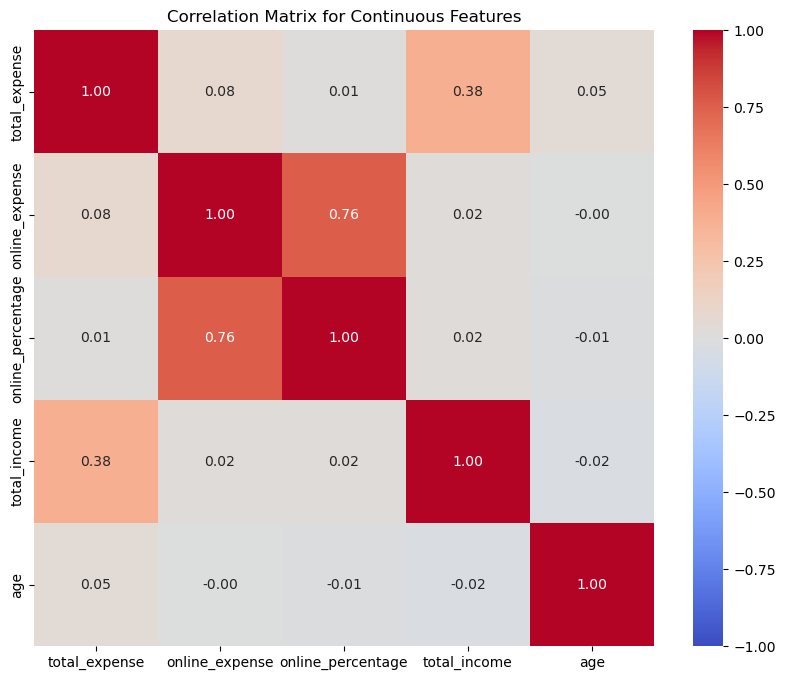

Selected Continuous Features after Correlation-Based Feature Selection:
['total_expense', 'online_expense', 'online_percentage', 'total_income', 'age']


In [ ]:
# Select only the continuous columns
df_continuous = df[continuous_cols]

# Compute the correlation matrix
corr_matrix = df_continuous.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix for Continuous Features')
plt.show()

# Feature selection: remove highly correlated features (correlation > 0.9)
threshold = 0.9
# Find pairs of features with correlation greater than the threshold
high_corr_vars = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr_vars.add(colname)

# Remove the highly correlated features
selected_continuous_cols = [col for col in continuous_cols if col not in high_corr_vars]


print("Selected Continuous Features after Correlation-Based Feature Selection:")
print(selected_continuous_cols)


## Regression Section ###

In this section, I will be employing 5 models for regression: Lasso, Elastic Net, Random Forest Regressor, XGBoost and Decision Tree Regressor. Please continue reading for a brief overview of the regression ML models.

### 1. **Lasso Regression**
Lasso (Least Absolute Shrinkage and Selection Operator) is a linear regression technique that incorporates L1 regularization to penalize large coefficients. It adds a constraint to the model that forces some of the coefficient estimates to be exactly zero, effectively performing feature selection. This regularization helps prevent overfitting, especially when the dataset has many features or potential multicollinearity. In the context of predicting the percentage of expenses spent on online shopping, Lasso can be effective if we suspect that only a small subset of continuous variables are meaningful predictors of the target variable. By penalizing irrelevant features, it helps to focus on the most influential ones, improving the model's generalization performance.

**Inputs:**
- Numerical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameter:**
- **Alpha:** Controls the strength of the L1 regularization, balancing model complexity and prediction accuracy.


### 2. **ElasticNet Regression**
ElasticNet is a linear regression model that combines the penalties of Lasso (L1) and Ridge (L2) regularization. It is particularly useful when there are multiple correlated features in the dataset, as it can both shrink coefficients and perform feature selection. The **l1_ratio** parameter controls the balance between Lasso (L1) and Ridge (L2) regularization, making it a flexible choice for regression tasks. In the case of predicting the percentage of expenses spent on online shopping, ElasticNet is appropriate when there might be collinearity among predictors, and we want a model that can both eliminate irrelevant variables and control for correlations between them. ElasticNet’s flexibility allows it to work well even in complex scenarios where other linear models may struggle.

**Inputs:**
- Numerical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameters:**
- **Alpha:** Controls the overall strength of regularization.
- **L1 Ratio:** Controls the balance between L1 and L2 regularization.

### 3. **Random Forest Regressor**
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy and control overfitting. It works by training many individual decision trees on random subsets of the data and aggregating their outputs. This model is robust to overfitting and can handle both linear and non-linear relationships between features and the target variable. In predicting online shopping spending, Random Forest can capture complex interactions between predictors (e.g., income, age, and education level) that may not be easily captured by linear models. This makes it suitable for tasks where the relationships between predictors and outcomes are intricate and non-linear.

**Inputs:**
- Numerical or categorical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameters:**
- **n_estimators:** Number of trees in the forest.
- **max_depth:** Maximum depth of each tree.
- **min_samples_split:** Minimum number of samples required to split a node.
- **min_samples_leaf:** Minimum number of samples required to be at a leaf node.

### 4. **XGBoost Regressor**
**XGBoost** is a powerful ensemble learning method that combines multiple decision trees to make predictions. It works iteratively, with each tree correcting the errors of the previous ones. Key hyperparameters include the learning rate, maximum depth of trees, and number of trees. XGBoost excels at handling complex relationships and often outperforms other regression algorithms. 

**Inputs:**
- Numerical or categorical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameters:**
- **Learning Rate:** Controls the step size at each iteration.
- **Maximum Depth:** Limits the depth of individual trees.
- **Number of Estimators:** Determines the number of trees in the ensemble.
- **Subsample:** Fraction of samples used for each tree.
- **Colsample_bytree:** Fraction of features used for each tree.

### 5. **Decision Tree Regressor**
**Decision Tree Regressor** is a simple yet effective model that makes decisions based on a series of if-else conditions. It recursively partitions the data into subsets, creating a tree-like structure. Key hyperparameters include the maximum depth of the tree, minimum samples per leaf, and minimum samples per split. While decision trees can be interpretable, they can be prone to overfitting, especially when the tree becomes too deep.

**Inputs:**
- Numerical or categorical features
- Target variable (continuous numerical value)

**Outputs:**
- Predicted numerical value for a given input

**Key Hyperparameters:**
- **Maximum Depth:** Controls the maximum depth of the tree.
- **Minimum Samples Split:** Minimum number of samples required to split a node.
- **Minimum Samples Leaf:** Minimum number of samples required to be at a leaf node.
- **Criterion:** The function to measure the quality of a split (e.g., MSE, MAE).


Model: Lasso
Best Parameters: {'alpha': 1, 'max_iter': 1000}
RMSE: 1.226
MAE: 0.859
R-squared: 0.305



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


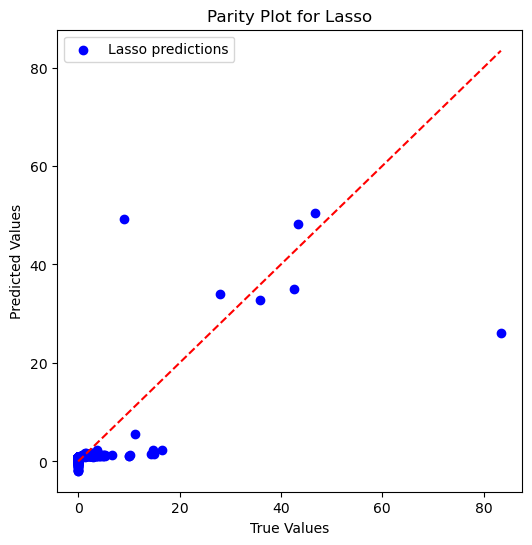

Model: ElasticNet
Best Parameters: {'alpha': 1, 'l1_ratio': 0.9, 'max_iter': 1000}
RMSE: 1.238
MAE: 0.872
R-squared: 0.291



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


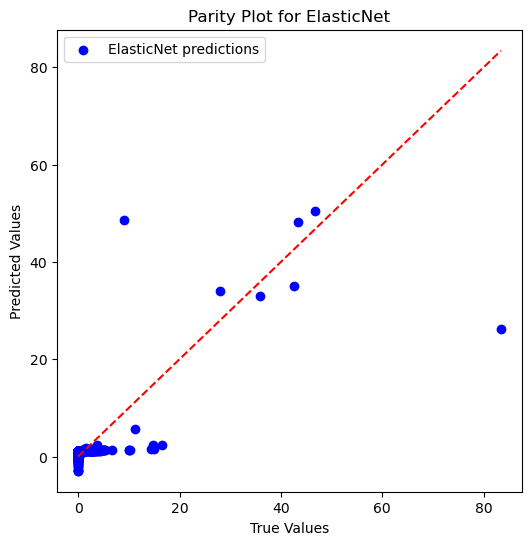

Model: RandomForestRegressor
Best Parameters: {'max_depth': 20, 'n_estimators': 15}
RMSE: 0.255
MAE: 0.011
R-squared: 0.970



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


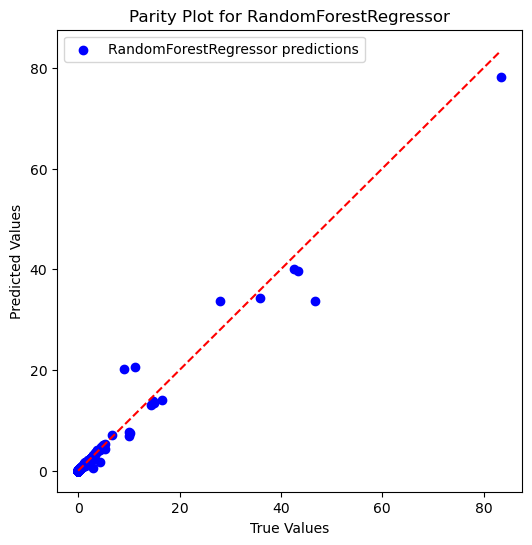

Model: XGBoost
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
RMSE: 0.182
MAE: 0.022
R-squared: 0.985



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


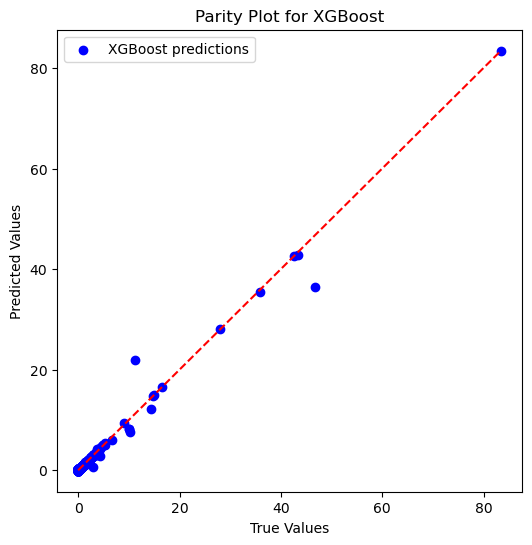

Model: DecisionTreeRegressor
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
RMSE: 0.446
MAE: 0.011
R-squared: 0.908



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


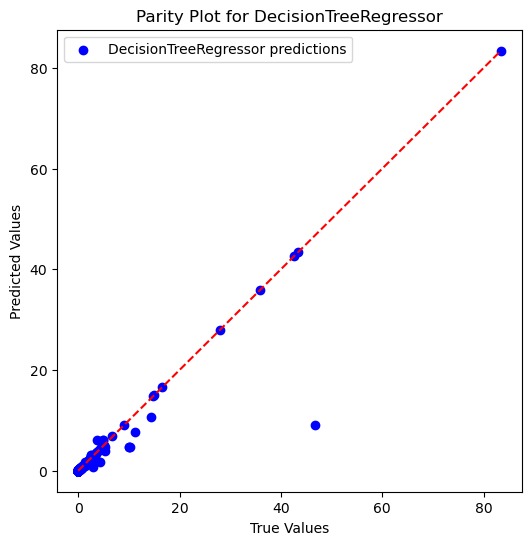

In [ ]:

# Research Question: Can we predict one's online shopping expenditure based on their annual earnings and expenses?
X_regression = df_continuous.drop(columns='online_percentage')
y_regression = df_continuous['online_percentage']

# Scale the features
scaler = StandardScaler()
X_regression_scaled = scaler.fit_transform(X_regression)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_regression_scaled, y_regression, test_size=0.2, random_state=42)

# Compute sample weights due to class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Model Selection and Training
models = {
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42)
}

# Model Tuning with GridSearchCV
for name, model in models.items():
    # Define the parameter grid for each model
    param_grid = {
        'Lasso': {'alpha': [0.01, 0.1, 0.5, 1, 10], 'max_iter': [1000]},
        'ElasticNet': {'alpha': [0.01, 0.1, 0.5, 1], 'l1_ratio': [0.1, 0.5, 0.9], 'max_iter': [1000]},
        'RandomForestRegressor': {'n_estimators': [5, 15, 25, 35, 45], 'max_depth': [10, 20, 30, None]},
        'XGBoost': {
            'n_estimators': [50, 100, 150, 200], 
            'learning_rate': [0.01, 0.05, 0.1], 
            'max_depth': [3, 5, 7], 
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        },
        'DecisionTreeRegressor': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5]}
    }

    # Perform GridSearchCV to find the best parameter combination
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_root_mean_squared_error')
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    # Best model
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate and print performance metrics
    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"R-squared: {r2_score(y_test, y_pred):.3f}\n")

    # Plotting predictions vs actual for comparison (parity plot)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, color='blue', label=f'{name} predictions')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Parity Plot for {name}")
    plt.legend()
    plt.show()


### **Model Results Interpretation**

#### **Lasso Regression**
Lasso is likely underfitting the data, possibly due to the linear nature of the model or an overly strong regularization parameter (alpha).

The RMSE of 1.226 indicates that, on average, the predicted values are off by approximately 1.226 units from the actual values. Since RMSE gives more weight to larger errors due to the squaring of the residuals, it suggests that Lasso might have some significant errors in predicting certain values.
The MAE of 0.859 means that, on average, the model's predictions deviate from the actual values by around 0.859 units. Unlike RMSE, MAE treats all errors equally, so this value gives an idea of the average magnitude of the prediction errors, which is relatively smaller than the RMSE.
An R-squared value of 0.305 indicates that the Lasso model explains only about 30.5% of the variance in the target variable. This suggests that Lasso has a relatively low explanatory power for the data, meaning that other factors not included in the model may be driving the target variable's behavior. The model is not capturing the underlying patterns well.

#### **ElasticNet Regression**
The ElasticNet model has a performance similar to Lasso in this case, with a slightly higher RMSE and MAE, and a similarly low R-squared value. However, it also appears to also be underfitting the data. It doesn't capture as much of the variance in the target variable, suggesting that the relationships in the data might be too complex or non-linear for ElasticNet to model effectively.

The RMSE of 1.238 indicates that, on average, the model's predictions are off by approximately 1.238 units from the true values. This error is relatively similar to the RMSE of the Lasso model (1.226), suggesting that ElasticNet also struggles to accurately predict the target variable.
The MAE of 0.872 means that, on average, the model's predictions deviate from the actual values by 0.872 units. This error is slightly higher than the MAE of Lasso (0.859), indicating that ElasticNet might be making slightly larger errors in its predictions compared to Lasso.
The R-squared value of 0.291 means that the ElasticNet model explains only 29.1% of the variance in the target variable. This is very similar to the Lasso model’s R-squared value (0.305), suggesting that ElasticNet does not perform much better in capturing the patterns of the data. The low R-squared indicates that ElasticNet is not a strong predictor in this case.

#### **RandomForestRegressor**
The RandomForest model is more capable of capturing complex relationships in the data, making it a more suitable choice for this regression task.

The RMSE of 0.255 shows that, on average, the predicted values are off by only 0.255 units from the actual values. This is a much smaller error compared to Lasso, suggesting that the RandomForestRegressor has a much better fit to the data. The MAE of 0.011 indicates that the average magnitude of the prediction errors is extremely low. This suggests that the model is very accurate in its predictions, with a minimal average deviation from the true values.
The R-squared value of 0.970 means that the RandomForestRegressor explains about 97% of the variance in the target variable. This indicates an excellent fit, with the model capturing most of the underlying patterns in the data. The high R-squared value indicates strong predictive power, meaning that the model is able to predict the target variable with high accuracy.

#### **XGBoost**
The XGBoost model has demonstrated exceptional performance in this regression task.

The low RMSE and MAE indicate that the model's predictions are very close to the actual values. This model has the lowest RMSE, but double the MAE of the RandomForestRegressor which is still quite low. The high R-squared value of 0.985 suggests that the model explains a significant portion of the variance in the target variable. This superior performance is likely due to XGBoost's ability to handle complex relationships and its robust ensemble learning approach.

#### **DecisionTreeRegressor**
While the Decision Tree Regressor has good performance, it falls short compared to XGBoost. Its higher RMSE, MAE, and lower R-squared suggest that it is less accurate in its predictions. This might be due to overfitting, where the model becomes too complex and struggles to generalize to new data.

**Table of Results**

| Model | RMSE | MAE | R-squared |
|---|---|---|---|
| Lasso | 1.226 | 0.859 | 0.305 |
| ElasticNet | 1.238 | 0.872 | 0.291 |
| RandomForestRegressor | 0.255 | 0.011 | 0.970 |
| XGBoost | 0.182 | 0.022 | 0.985 |
| DecisionTreeRegressor | 0.446 | 0.011 | 0.908 |



#### Explanaton of metrics
- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values. A smaller RMSE indicates better model accuracy.
- **MAE (Mean Absolute Error)**: Similar to RMSE but without the squared term. It gives a more direct measure of prediction accuracy by averaging absolute differences.
- **R-squared**: Indicates the proportion of variance in the target variable explained by the model. An R-squared of 1 means perfect predictions, and 0 means no explanatory power.

The parity plots show how well the predicted values match the actual values, with the ideal result being a 45-degree line indicating perfect predictions. For Lasso and ElasticNet, the line seems to somewhat align with the points but two far away points most likely caused the underfitting, whereas the Random Forest, XGBoost and Decision Tree models shows a closer match to the ideal line, indicating good prediction accuracy.

## Key Insights from Analysis

Using XGBoost and Random Forest Regressor, we can effectively address our research question, "Can we predict one's online shopping expenditure based on their annual earnings and expenses?".

**Model Performance:**

- **XGBoost** and **Random Forest** significantly outperform **Lasso** and **ElasticNet**. 
- **XGBoost** appears to be the best-performing model based on the provided metrics.
- **Decision Tree Regressor** performs reasonably well but lags behind XGBoost and Random Forest.

**Model Limitations:**

- **Lasso** and **ElasticNet** struggle with complex relationships in the data, leading to underfitting.
- **Decision Tree Regressor** might be prone to overfitting.

**Key Takeaways:**

- **Ensemble methods** like Random Forest and XGBoost are powerful tools for handling complex relationships and reducing overfitting.
- **Regularization techniques** like Lasso and Elastic Net can be useful for feature selection and preventing overfitting in linear models.
- **Model selection** is crucial. The best model for a specific problem depends on factors like data complexity, interpretability requirements, and computational resources.
- For this specific research question, the **Random Forest Regressor** and **XGBoost** are the most suitable models.

Overall, the analysis highlights the importance of choosing the right model for the specific problem and the data at hand. In this case, a more flexible and powerful model like Random Forest and XGBoost was able to capture the underlying patterns and provide more accurate predictions.

---

## Binary Classification Section

In this section, I will be employing 6 models for binary classification: Logistic Regression, Random Forest Classifier, Linear Support Vector Classification (LinearSVC), Decision Tree Classifier, Naive Bayes (GaussianNB), and K Nearest Neighbors (KNN). Please continue reading for a brief overview of these classification ML models. Please note, that these models are capable of doing multi-class classifiation, too, so I will use them in the Multi-class Classification Section.

### Logistic Regression

**How it works:** Logistic regression models the probability of a binary outcome. It uses a logistic function to map a linear combination of features to a probability between 0 and 1. The model learns the coefficients of the linear combination during training. 

**Inputs:**
* Numerical or categorical features

**Outputs:**
* Probability of belonging to a specific class (0 or 1)

**Key Hyperparameter:**
* **Regularization strength (C):** Controls the trade-off between model complexity and overfitting.

### Random Forest Classifier

**How it works:** Random Forest is an ensemble method that combines multiple decision trees. Each tree is trained on a random subset of the data and features. The final prediction is made by averaging the predictions of all trees. This ensemble approach helps reduce overfitting and improve generalization. 

**Inputs:**
* Numerical or categorical features

**Outputs:**
* Predicted class label

**Key Hyperparameters:**
* **n_estimators:** Number of trees in the forest.
* **max_depth:** Maximum depth of each tree.
* **min_samples_split:** Minimum number of samples required to split a node.
* **min_samples_leaf:** Minimum number of samples required to be at a leaf node.

### Linear Support Vector Classification (LinearSVC)

**How it works:** LinearSVC finds the optimal hyperplane that separates the data into two classes. It maximizes the margin between the classes while minimizing classification errors. The model learns the coefficients of the hyperplane during training.

**Inputs:**
* Numerical features

**Outputs:**
* Predicted class label

**Key Hyperparameter:**
* **C:** Regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors.

### Decision Tree Classifier

**How it works:** A decision tree classifier creates a tree-like model of decisions and their possible consequences. Each node in the tree represents a decision based on a feature, and each branch represents a possible outcome. The leaves of the tree represent the predicted class.

**Inputs:**
* Numerical or categorical features

**Outputs:**
* Predicted class label

**Key Hyperparameters:**
* **max_depth:** Maximum depth of the tree.
* **min_samples_split:** Minimum number of samples required to split a node.
* **min_samples_leaf:** Minimum number of samples required to be at a leaf node.
* **criterion:** Function to measure the quality of a split (e.g., Gini impurity, entropy).

### Naive Bayes (GaussianNB)

**How it works:** Naive Bayes assumes that features are independent given the class label. It calculates the probability of a class given the feature values using Bayes' theorem. For numerical features, it assumes a Gaussian distribution.

**Inputs:**
* Numerical features

**Outputs:**
* Predicted class label

**Key Hyperparameter:**
* **var_smoothing:** A small value added to the variance to avoid division by zero.

### K-Nearest Neighbors (KNN)

**How it works:** KNN classifies a data point based on the majority class of its k nearest neighbors. The distance between data points is calculated using a distance metric like Euclidean distance. The model simply stores the training data and classifies new data points by finding their nearest neighbors

**Inputs:**
* Numerical features

**Outputs:**
* Predicted class label

**Key Hyperparameter:**
* **n_neighbors:** Number of neighbors to consider.

**XGBoost Classifier**

XGBoost (eXtreme Gradient Boosting) is a powerful ensemble learning method that combines multiple decision trees to make accurate predictions. It's a popular choice for both regression and classification tasks due to its efficiency and high performance.

**How it works:**
1. **Base Model:** An initial simple model (e.g., a decision tree) is trained on the entire dataset.
2. **Residual Learning:** The errors or residuals from the base model are calculated.
3. **Subsequent Models:** New models are trained to predict these residuals, focusing on the parts of the data where the base model underperformed.
4. **Ensemble:** The predictions from all the models are combined to form the final prediction.

**Inputs:**

* Numerical or categorical features
* Target variable (class labels)

**Outputs:**

* Predicted class label

**Key Hyperparameters:**

* **n_estimators:** Number of trees in the ensemble.
* **max_depth:** Maximum depth of each tree.
* **learning_rate:** Step size at each iteration.
* **subsample:** Fraction of samples used for training each tree.
* **colsample_bytree:** Fraction of features used for each tree.
* **gamma:** Minimum loss reduction required to make a split.
* **lambda:** L2 regularization term.
* **alpha:** L1 regularization term.


**Note on Box-Cox Transformed features:** While the Box-Cox transformation is typically used for continuous response variables in linear regression, it can indirectly benefit logistic regression by improving the quality of the underlying data. By transforming skewed or non-normal features, Box-Cox can make the data more suitable for modeling, which can in turn improve the performance of logistic regression. Additionally, a well-distributed dataset can help the optimization algorithms used in logistic regression converge more efficiently.
While Box-Cox transformation is often used to improve the performance of linear regression models, it may not be as beneficial for the following models:

For Random Forest Classifier, Decision Tree Classifier, and K-Nearest Neighbors: These models are non-parametric and can handle non-linear relationships and non-normal distributions. They are less sensitive to the specific distribution of the input features. Therefore, applying a Box-Cox transformation might not have a significant impact on their performance.

For Linear Support Vector Classification (LinearSVC): Similar to logistic regression, LinearSVC is a linear model. However, the focus is on finding the optimal hyperplane to separate the classes. While Box-Cox can improve the distribution of features, it may not directly impact the decision boundary.

For Naive Bayes (GaussianNB): Naive Bayes assumes that features are independent given the class label. While Box-Cox can improve the normality of features, it may not significantly impact the independence assumption. Moreover, Naive Bayes is often robust to non-normality, especially with larger datasets.

In [ ]:
# Research Question: Predict whether the individual has shopped online (binary classification)

# For Logistic Regression (Box-Cox-transformed data)
boxcox_binary_class_df = df[boxcox_combined_cols]
X_binary_boxcox = boxcox_binary_class_df.drop(columns='bought_online')
y_binary_boxcox = boxcox_binary_class_df['bought_online']

# For all other models
binary_class_df = df[combined_cols]
X_binary = binary_class_df.drop(columns='bought_online')
y_binary = binary_class_df['bought_online']

# Feature Selection: Chi-square test for X_binary and y_binary
print("Chi-Square Test P-values for X_binary:")
chi2_selector = SelectKBest(chi2, k='all')
X_selected = chi2_selector.fit_transform(X_binary, y_binary)
p_values = chi2_selector.pvalues_

for feature, p_value in zip(X_binary.columns, p_values):
    print(f"{feature}: {p_value}")

selected_features = [feature for feature, p_value in zip(X_binary.columns, p_values) if p_value < 0.05]
print(f"Selected features after Chi-square test for X_binary: {selected_features}")

# Feature Selection: Chi-square test for X_binary_boxcox and y_binary_boxcox
print("\nChi-Square Test P-values for X_binary_boxcox:")
chi2_selector_boxcox = SelectKBest(chi2, k='all')
X_selected_boxcox = chi2_selector_boxcox.fit_transform(X_binary_boxcox, y_binary_boxcox)
p_values_boxcox = chi2_selector_boxcox.pvalues_

for feature, p_value in zip(X_binary_boxcox.columns, p_values_boxcox):
    print(f"{feature}: {p_value}")

selected_features_boxcox = [
    feature for feature, p_value in zip(X_binary_boxcox.columns, p_values_boxcox) if p_value < 0.05
]
print(f"Selected features after Chi-square test for X_binary_boxcox: {selected_features_boxcox}")


Chi-Square Test P-values for X_binary:
total_expense: 0.0
online_expense: 0.0
online_percentage: 0.0
total_income: 0.0
age: 0.0
is_asian: 0.15217685907720935
is_black: 0.00010982947325401559
race_unknown: 0.8565030475655357
is_native_american: 0.9530915532317705
is_other_race: 0.017870176187389987
is_pacific_islander: 0.6725904811311745
is_white: 8.001865448028292e-16
full_time_1_yr: 0.02002474394092006
part_time_1_yr: 0.14289030645293085
full_time_part_yr: 0.03519145383551706
part_time_part_yr: 0.1321589921988693
no_school_completed: 0.009528197065347776
grades_1-8_completed: 2.4342758686852012e-06
high_school_no_degree: 3.122036264295844e-13
high_school_grad: 1.3594354087167185e-16
some_college_no_degree: 0.0012611977680571321
associates_degree: 0.021838468961397538
bachelors_degree: 9.741894922105698e-20
graduate_degree: 6.367416256986332e-19
is_married: 0.0009441136963829701
is_widowed: 5.249195925305053e-09
is_divorced: 0.0031962842508815727
is_separated: 0.07999737450506256
is_si

Selected features after Chi-square test for X_binary: ['total_expense', 'online_expense', 'online_percentage', 'total_income', 'age', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'full_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced']

Selected features after Chi-square test for X_binary_boxcox: ['boxcox_total_expense', 'boxcox_online_expense', 'boxcox_online_percent', 'boxcox_total_income', 'age', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'full_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced']


Model: LogisticRegression
Best Parameters: {'C': 0.01}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852


Model: RandomForestClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 5}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852


Model: LinearSVC
Best Parameters: {'C': 1}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7290
           1       1.00      0.86      0.93       56

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:42:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:42:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:42:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/pytho


Model: XGBoostClassifier
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:42:26] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


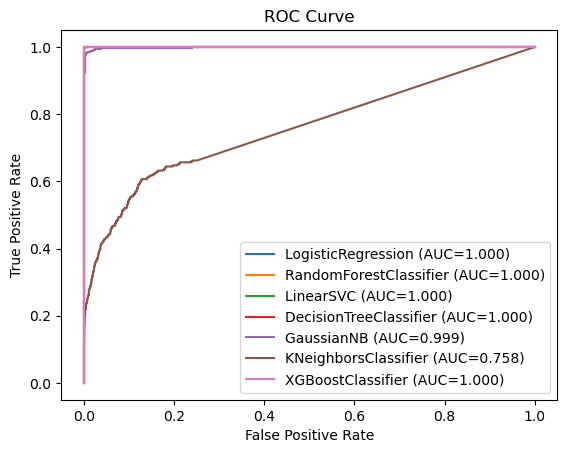

In [31]:
# Reassign datasets with selected features
X_binary_selected = X_binary[selected_features]
X_binary_boxcox_selected = X_binary_boxcox[selected_features_boxcox]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_binary_selected, y_binary, test_size=0.2, random_state=42
)
# Standardize features for SVC and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split the Box-Cox transformed data for Logistic Regression
X_train_boxcox, X_test_boxcox, y_train_boxcox, y_test_boxcox = train_test_split(
    X_binary_boxcox_selected, y_binary_boxcox, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class (only for Logistic Regression)
smote_boxcox = SMOTE(random_state=42)
X_train_resampled_boxcox, y_train_resampled_boxcox = smote_boxcox.fit_resample(X_train_boxcox, y_train_boxcox)


# Model Selection and Training
models = {
    'LogisticRegression': LogisticRegression(max_iter=50000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=50000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBoostClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    # Define parameter grid for GridSearchCV
    param_grid = {
        'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 20, 30, 50]},
        'RandomForestClassifier': {'n_estimators': [5, 15, 25, 35, 45, 55, 75, 105], 'max_depth': [10, 20, 30, None]},
        'LinearSVC': {'C': [0.01, 0.1, 1, 10, 100]},
        'DecisionTreeClassifier': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]},
        'GaussianNB': {},  # No hyperparameters for GaussianNB
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
        'XGBoostClassifier': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    }

    # Adjust training data for specific models
    if name == 'LogisticRegression':
        X_train_model = X_train_resampled_boxcox
        y_train_model = y_train_resampled_boxcox
        X_test_model = X_test_boxcox
        y_test_model = y_test_boxcox
    elif name in ['LinearSVC', 'KNeighborsClassifier']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        y_train_model = y_train
        y_test_model = y_test

    # GridSearchCV to find the best model
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='roc_auc')
    grid_search.fit(X_train_model, y_train_model)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_model)

    # Print classification report
    print(f"\nModel: {name}")
    print(f"Best Parameters: {grid_search.best_params_ if param_grid[name] else 'Default Parameters'}")
    print(classification_report(y_test_model, y_pred))

    # Plot ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test_model)[:, 1]
    else:  # For models like LinearSVC without `predict_proba`
        y_prob = best_model.decision_function(X_test_model)

    fpr, tpr, _ = roc_curve(y_test_model, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test_model, y_prob):.3f})')

# Show ROC plot
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


### Summary of Results for Binary Classification

#### Logistic Regression:
- **AUC**: 1.00
- **Performance**: Perfect classification with a 100% precision, recall, and F1-score for both classes. The model demonstrates perfect generalization on the test data.

#### Random Forest Classifier:
- **AUC**: 1.00
- **Performance**: Identical to Logistic Regression, with perfect precision, recall, and F1-score for both classes. The model is highly effective at distinguishing between online and in-store shoppers.

#### LinearSVC:
- **AUC**: 1.00
- **Performance**: Overall accuracy is 99%, with a slight drop in recall (86%) for the minority class (online shoppers). This indicates the model struggles to identify all online shoppers compared to other models.

#### Decision Tree Classifier:
- **AUC**: 1.00
- **Performance**: Perfect classification metrics, matching Logistic Regression and Random Forest. The model is highly interpretable, which is an added advantage for decision-making.

#### Gaussian Naive Bayes:
- **AUC**: 0.999
- **Performance**: Accuracy and precision for the majority class are near-perfect, but recall for the minority class drops slightly to 96%. This suggests some difficulty in capturing all online shoppers.

#### K-Nearest Neighbors (KNN):
- **AUC**: 0.758
- **Performance**: Significantly lower performance than other models. The recall for online shoppers is only 20%, leading to poor F1-scores. This model struggles to differentiate between the classes effectively.

#### XGBoost Classifier

- **AUC**: 1
- **Performance:** Perfect classification metrics across the board. XGBoost efficiently learned complex patterns with a modest depth, confirming its robustness and adaptability to various data distributions.


### Insights Gained

1. **Class Imbalance Management**: Models like Logistic Regression and Random Forest can handle imbalanced data effectively, likely aided by resampling and hyperparameter tuning.

2. **Feature Importance**: Tree-based models like Random Forest and Decision Tree provide insights into feature importance, allowing us to identify key predictors for online shopping behavior.

3. **Scalability**: Logistic Regression and Decision Tree are computationally efficient and scalable to larger datasets, making them more practical for real-world applications compared to resource-intensive models like KNN.

4. **Interpretability**: Decision Tree is the most interpretable model, which is valuable for explaining predictions to stakeholders and identifying actionable insights.

5. **Limitations of Non-linear Models**: Despite being theoretically powerful, models like KNN and LinearSVC fail to outperform simpler models in this case. This highlights the importance of model selection based on the dataset's characteristics.

### Conclusion
From this analysis, we can confidently predict whether an individual has shopped online based on the dataset. The results suggest that the dataset is highly structured, with features that strongly differentiate between the two classes. Logistic Regression, Random Forest, Decision Tree, and XGBoost are all excellent choices, with XGBoost offering the best combination of robustness, flexibility and generalizability. GaussianNB and LinearSVC also provide competitive performance, though they require careful handling of class imbalance. KNN, on the other hand, is unsuitable for this problem.


In [32]:
# Research Question: Can we predict one's sex based on their demographics and financial information? (binary classification)
# For RandomorestClassifier
binary_class_df = df[combined_cols]
X_binary2 = binary_class_df.drop(columns=['is_male', 'is_female'])
y_binary2 = binary_class_df['is_female']

# For Logistic Regression (Box-Cox-transformed data)
boxcox_binary_class_df = df[boxcox_combined_cols]
X_binary_boxcox = boxcox_binary_class_df.drop(columns=['is_male', 'is_female'])
y_binary_boxcox = boxcox_binary_class_df['is_female']

# Feature Selection: Chi-square test for X_binary2 and y_binary2
print("Chi-Square Test P-values for X_binary2:")
chi2_selector = SelectKBest(chi2, k='all')
X_selected = chi2_selector.fit_transform(X_binary2, y_binary2)
p_values = chi2_selector.pvalues_

for feature, p_value in zip(X_binary2.columns, p_values):
    print(f"{feature}: {p_value}")

selected_features = [feature for feature, p_value in zip(X_binary2.columns, p_values) if p_value < 0.05]
print(f"Selected features after Chi-square test for X_binary2: {selected_features}")

# Feature Selection: Chi-square test for X_binary_boxcox and y_binary_boxcox (Logistic Regression)
print("\nChi-Square Test P-values for X_binary_boxcox:")
chi2_selector_boxcox = SelectKBest(chi2, k='all')
X_selected_boxcox = chi2_selector_boxcox.fit_transform(X_binary_boxcox, y_binary_boxcox)
p_values_boxcox = chi2_selector_boxcox.pvalues_

for feature, p_value in zip(X_binary_boxcox.columns, p_values_boxcox):
    print(f"{feature}: {p_value}")

selected_features_boxcox = [
    feature for feature, p_value in zip(X_binary_boxcox.columns, p_values_boxcox) if p_value < 0.05
]
print(f"Selected features after Chi-square test for X_binary_boxcox: {selected_features_boxcox}")




Chi-Square Test P-values for X_binary2:
total_expense: 0.0
online_expense: 0.0
online_percentage: 0.32085839731287025
total_income: 0.0
age: 6.600157665938713e-281
is_asian: 0.9252760002939772
is_black: 0.000602041688322881
race_unknown: 0.9799163104810702
is_native_american: 0.9864661620641817
is_other_race: 0.26684487185243716
is_pacific_islander: 0.6707534546985924
is_white: 1.525997648409876e-05
full_time_1_yr: 7.68707920365536e-56
part_time_1_yr: 1.5321350474188765e-23
full_time_part_yr: 0.0040576724745267105
part_time_part_yr: 4.650379050519512e-11
no_school_completed: 0.6706190207445876
grades_1-8_completed: 0.5084663266156371
high_school_no_degree: 0.00334200198814014
high_school_grad: 8.143159091514547e-07
some_college_no_degree: 0.3889907240314002
associates_degree: 2.8731267399412588e-06
bachelors_degree: 0.0007346650531785444
graduate_degree: 1.949146727486516e-07
is_married: 4.302997819087806e-06
is_widowed: 1.9519462374024126e-111
is_divorced: 8.136950833854062e-23
is_sep

Selected features after Chi-square test for X_binary2: ['total_expense', 'online_expense', 'total_income', 'age', 'is_black', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr', 'high_school_no_degree', 'high_school_grad', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single']


Selected features after Chi-square test for X_binary_boxcox: ['boxcox_total_income', 'age', 'is_black', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr', 'high_school_no_degree', 'high_school_grad', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single']


Model: LogisticRegression
Best Parameters: {'C': 20}
              precision    recall  f1-score   support

           0       0.54      0.66      0.59      3726
           1       0.61      0.48      0.54      4126

    accuracy                           0.57      7852
   macro avg       0.57      0.57      0.57      7852
weighted avg       0.58      0.57      0.56      7852


Model: RandomForestClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 5}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      0.99      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852


Model: LinearSVC
Best Parameters: {'C': 10}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7290
           1       1.00      0.88      0.94       562

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:44:41] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:44:41] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:44:41] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/pytho


Model: XGBoostClassifier
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



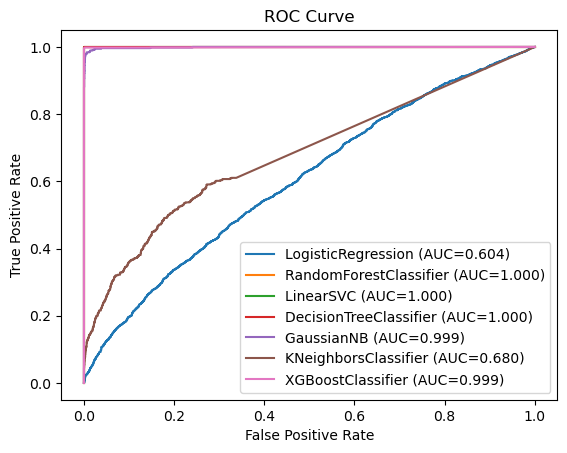

In [33]:
# Reassign datasets with selected features
X_binary_selected = X_binary2[selected_features]
X_binary_boxcox_selected = X_binary_boxcox[selected_features_boxcox]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_binary_selected, y_binary, test_size=0.2, random_state=42
)
# Standardize features for SVC and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Split the Box-Cox transformed data for Logistic Regression
X_train_boxcox, X_test_boxcox, y_train_boxcox, y_test_boxcox = train_test_split(
    X_binary_boxcox_selected, y_binary_boxcox, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class (only for Logistic Regression)
smote_boxcox = SMOTE(random_state=42)
X_train_resampled_boxcox, y_train_resampled_boxcox = smote_boxcox.fit_resample(X_train_boxcox, y_train_boxcox)


# Model Selection and Training
models = {
    'LogisticRegression': LogisticRegression(max_iter=50000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=50000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBoostClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


for name, model in models.items():
    # Define parameter grid for GridSearchCV
    param_grid = {
        'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 20, 30, 50]},
        'RandomForestClassifier': {'n_estimators': [5, 15, 25, 35, 45, 55, 75, 105], 'max_depth': [10, 20, 30, None]},
        'LinearSVC': {'C': [0.01, 0.1, 1, 10, 100]},
        'DecisionTreeClassifier': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]},
        'GaussianNB': {},  # No hyperparameters for GaussianNB
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
        'XGBoostClassifier': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    }

    # Adjust training data for specific models
    if name == 'LogisticRegression':
        X_train_model = X_train_resampled_boxcox
        y_train_model = y_train_resampled_boxcox
        X_test_model = X_test_boxcox
        y_test_model = y_test_boxcox
    elif name in ['LinearSVC', 'KNeighborsClassifier']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        y_train_model = y_train
        y_test_model = y_test

    # GridSearchCV to find the best model
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='roc_auc')
    grid_search.fit(X_train_model, y_train_model)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_model)

    # Print classification report
    print(f"\nModel: {name}")
    print(f"Best Parameters: {grid_search.best_params_ if param_grid[name] else 'Default Parameters'}")
    print(classification_report(y_test_model, y_pred))

    # Plot ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test_model)[:, 1]
    else:  # For models like LinearSVC without predict_proba
        y_prob = best_model.decision_function(X_test_model)

    fpr, tpr, _ = roc_curve(y_test_model, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test_model, y_prob):.3f})')

# Show ROC plot
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### **Summary of Each Model's Performance**

1. **Logistic Regression**:
   - **AUC**: 0.604
   - **Performance**:  
     - Accuracy: 57%.  
     - Precision, recall, and F1-scores for both classes hover around 0.54–0.61, indicating a modest ability to distinguish between the two sexes.  
     - The model struggles to balance recall for both classes, with recall for class 0 (male) at 0.66 and class 1 (female) at 0.48.
     - The relatively low scores suggest that the relationship between features and the target is not entirely linear or that additional preprocessing is needed.

2. **Random Forest Classifier**:
   - **AUC**: 1.00
   - **Performance**:  
     - Perfect scores (accuracy, precision, recall, F1-score) across all metrics.  
     - However, the low minority class size (class 1: 562 samples) raises concerns about potential overfitting.

3. **LinearSVC**:
   - **AUC**: 1.00
   - **Performance**:  
     - Accuracy: 99%.  
     - Strong overall performance, but recall for class 1 (female) drops slightly to 0.88, leading to a lower F1-score (0.94).
     - Performs slightly worse than the tree-based models, with a slight drop in recall for class 1 (female). Still, the high accuracy (99%) suggests good generalization potential.

4. **Decision Tree Classifier**:
   - **AUC**: 1.00
   - **Performance**:  
     - Perfect performance across all metrics (accuracy, precision, recall, F1-score).  
     - Simpler architecture (shallow tree) suggests good separation of demographic and financial features to predict sex.

5. **Gaussian Naive Bayes**:
   - **AUC**: 0.999
   - **Performance**:  
     - Accuracy: 100%. Excellent performance overall, though recall for class 1 (female) is slightly reduced to 0.96.  
     - The reliance on strong independence assumptions may make the model slightly less robust in more complex datasets.
     - Nearly matches the performance of the top models but shows minor weaknesses in recall for the minority class (female). The simplicity and speed of this model may make it an attractive choice in scenarios where interpretability and efficiency are critical.

6. **K-Nearest Neighbors (KNN)**:
   - **AUC**: 0.680
   - **Performance**:  
     - Accuracy: 93%, but performance on the minority class is poor.  
     - Recall for class 1 (female) is 0.11, leading to a very low F1-score (0.19).  
     - Struggles with imbalanced datasets, over-prioritizing the majority class.
  

7. **XGBoost Classifier**:
   - **AUC**: 0.999
   - **Performance**:  
     - Perfect performance across all metrics (accuracy, precision, recall, F1-score), showing it effectively captures patterns in the data.


### **Insights Gained**

1. **Feature Importance**:  
   Tree-based models and XGBoost highlight that demographic and financial features strongly differentiate between sexes, as these models achieve near-perfect or perfect performance.

2. **Class Imbalance**:  
   Logistic Regression and KNN struggle with imbalanced datasets, emphasizing the importance of balancing techniques such as oversampling, SMOTE, or class-weight adjustments.

3. **Model Robustness**:  
   Despite their excellent performance, the tree-based models and XGBoost might be overfitting due to the small minority class size. Validation on an external dataset is crucial to confirm these results.

4. **Linear Models**:  
   Logistic Regression's modest performance highlights the limitations of linear models in capturing complex relationships. Still, it may provide valuable baseline insights.

5. **Predictive Insights**:  
   The data suggests that sex can be predicted with high accuracy using demographic and financial features. This indicates underlying patterns, though care should be taken to avoid overgeneralization or bias in practical applications.


### **Recommendation**
Implement XGBoost due to its robust performance, ability to capture non-linear relationships and interactions between features, built-in regularization to reduce overfitting, efficiency and explainability. 

---

## Multi-class Classification Section 

In this section, I will be employing 7 models for multi-class classification: Logistic Regression, Random Forest Classifier, Linear Support Vector Classification (LinearSVC), Decision Tree Classifier, Naive Bayes (GaussianNB), K Nearest Neighbors (KNN), and XGBoost (XGBoostClassifier). Please refer to the Binary Classification Section for an overview on each of these methods.

In [ ]:
# Research Question: Can we predict education level based on demographic and financial information?
ed_dict = {'no school completed': 1, 'grades 1-8': 2, 'high school no degree': 3, 'high school grad': 4, 'some college no degree': 5, 
           'associates degree': 6, 'bachelors degree': 7, 'graduate degree': 8}
earning_dict = {'full-time 1 year': 1,'part-time 1 year': 2, 'full-time part year': 3, 'part-time part year': 4}

# For Logistic Regression (Box-Cox-transformed data)

# Ensure consistent dropping of missing values
boxcox_multi_df = df[boxcox_combined_cols + target_cols]

# A little data cleaning to convert strings to numerical values
boxcox_multi_df['highest_ed_completed'] = boxcox_multi_df['highest_ed_completed'].replace(ed_dict)
boxcox_multi_df['earning_type'] = boxcox_multi_df['earning_type'].replace(earning_dict)

# Drop rows with missing values jointly
boxcox_multi_df.dropna(inplace=True)

X_multi_boxcox = boxcox_multi_df.drop(columns='highest_ed_completed')
y_multi_boxcox = boxcox_multi_df['highest_ed_completed']

# Repeat the same process for the original data
multi_df = df[combined_cols + target_cols]
multi_df['highest_ed_completed'] = multi_df['highest_ed_completed'].replace(ed_dict)
multi_df['earning_type'] = multi_df['earning_type'].replace(earning_dict)

multi_df.dropna(inplace=True)

X_multi = multi_df.drop(columns='highest_ed_completed')
y_multi = multi_df['highest_ed_completed']

# We'll first start by predicting education

# Feature Selection: Chi-square test for X_multi_boxcox and y_multi_boxcox (Logistic Regression)
print("\nChi-Square Test P-values for X_multi_boxcox:")
chi2_selector_boxcox = SelectKBest(chi2, k='all')
X_selected_boxcox = chi2_selector_boxcox.fit_transform(X_multi_boxcox, y_multi_boxcox)
p_values_boxcox = chi2_selector_boxcox.pvalues_

for feature, p_value in zip(X_multi_boxcox.columns, p_values_boxcox):
    print(f"{feature}: {p_value}")

selected_features_boxcox = [
    feature for feature, p_value in zip(X_multi_boxcox.columns, p_values_boxcox) if p_value < 0.05
]
print(f"Selected features after Chi-square test for X_multi_boxcox: {selected_features_boxcox}")

# Feature Selection: Chi-square test for X_multi and y_multi
print("Chi-Square Test P-values for X_multi:")
chi2_selector = SelectKBest(chi2, k='all')
X_selected = chi2_selector.fit_transform(X_multi, y_multi)
p_values = chi2_selector.pvalues_

for feature, p_value in zip(X_multi.columns, p_values):
    print(f"{feature}: {p_value}")

selected_features = [feature for feature, p_value in zip(X_multi.columns, p_values) if p_value < 0.05]
print(f"Selected features after Chi-square test for X_multi: {selected_features}")



Chi-Square Test P-values for X_multi_boxcox:
boxcox_total_expense: 0.0
boxcox_online_expense: 1.6949067043284817e-14
boxcox_online_percent: 0.9999992283185265
boxcox_total_income: 0.0
age: 0.0
is_asian: 1.2790815368242272e-31
is_black: 2.8484159018012748e-08
race_unknown: 0.9347061978986386
is_native_american: 0.9907853527116911
is_other_race: 2.9304062839162014e-39
is_pacific_islander: 0.9919907294475497
is_white: 2.0777023293482254e-32
full_time_1_yr: 6.682280315849476e-32
part_time_1_yr: 5.191270544800448e-26
full_time_part_yr: 2.0481108956825317e-07
part_time_part_yr: 3.9777429419726197e-112
no_school_completed: 0.0
grades_1-8_completed: 0.0
high_school_no_degree: 0.0
high_school_grad: 0.0
some_college_no_degree: 0.0
associates_degree: 0.0
bachelors_degree: 0.0
graduate_degree: 0.0
is_married: 1.890173690031541e-67
is_widowed: 5.604309923121948e-08
is_divorced: 1.8914547356741404e-09
is_separated: 3.915215371233994e-18
is_single: 1.8320372228215296e-95
is_female: 1.723534472738352

/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_30675/1428796177.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  boxcox_multi_df['highest_ed_completed'] = boxcox_multi_df['highest_ed_completed'].replace(ed_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_30675/1428796177.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxcox_multi_df['highest_ed_completed'] = boxcox_multi_df['highest_ed_completed'].replace(ed_dict)
/var/folders/sm/dt8s0j7j0glg1jfrlpndm0lw0000gn/T/ipykernel_30675/142

Selected features after Chi-square test for X_multi_boxcox: ['boxcox_total_expense', 'boxcox_online_expense', 'boxcox_total_income', 'age', 'is_asian', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single', 'is_female', 'is_male', 'bought_online', 'earning_type']


Selected features after Chi-square test for X_multi: ['total_expense', 'online_expense', 'online_percentage', 'total_income', 'age', 'is_asian', 'is_black', 'is_other_race', 'is_white', 'full_time_1_yr', 'part_time_1_yr', 'full_time_part_yr', 'part_time_part_yr', 'no_school_completed', 'grades_1-8_completed', 'high_school_no_degree', 'high_school_grad', 'some_college_no_degree', 'associates_degree', 'bachelors_degree', 'graduate_degree', 'is_married', 'is_widowed', 'is_divorced', 'is_separated', 'is_single', 'is_female', 'is_male', 'bought_online', 'earning_type']

Model: LogisticRegression
Best Parameters: {'C': 10}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



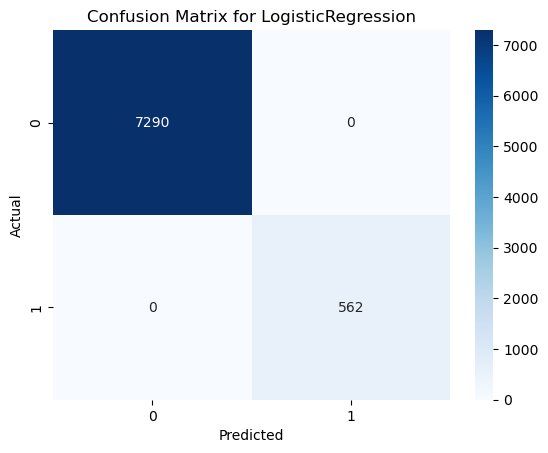

Model: RandomForestClassifier
Best Parameters: {'max_depth': 10, 'n_estimators': 45}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



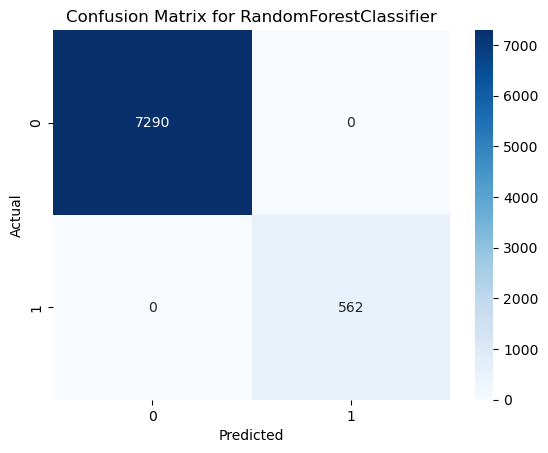

Model: LinearSVC
Best Parameters: {'C': 0.01}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7290
           1       1.00      0.86      0.93       562

    accuracy                           0.99      7852
   macro avg       0.99      0.93      0.96      7852
weighted avg       0.99      0.99      0.99      7852



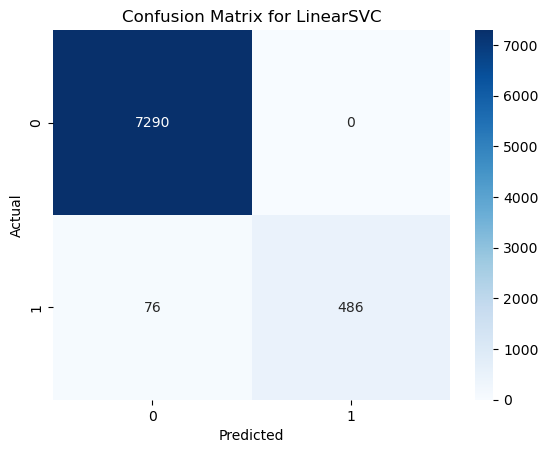

Model: DecisionTreeClassifier
Best Parameters: {'max_depth': 5, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



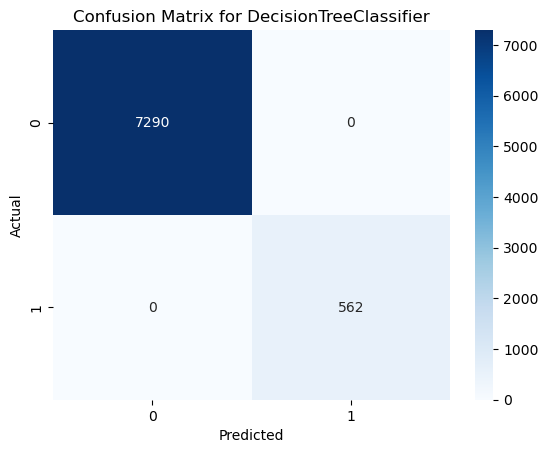

Model: GaussianNB
Best Parameters: {}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       0.97      0.96      0.97       562

    accuracy                           1.00      7852
   macro avg       0.99      0.98      0.98      7852
weighted avg       1.00      1.00      1.00      7852



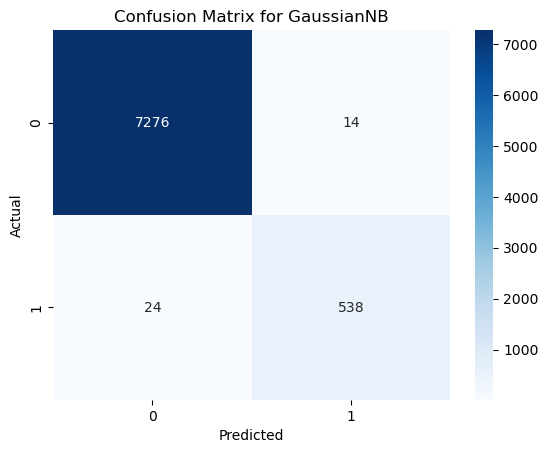

Model: KNeighborsClassifier
Best Parameters: {'n_neighbors': 9, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7290
           1       0.94      0.85      0.89       562

    accuracy                           0.99      7852
   macro avg       0.97      0.92      0.94      7852
weighted avg       0.99      0.99      0.98      7852



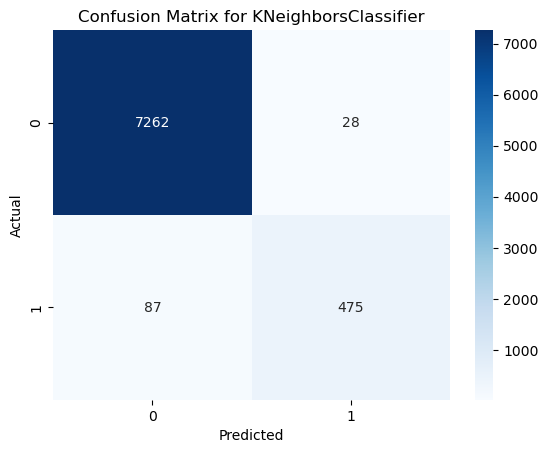

/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:03:01] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:03:02] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:03:02] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/testenv/lib/pytho

Model: XGBoostClassifier
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7290
           1       1.00      1.00      1.00       562

    accuracy                           1.00      7852
   macro avg       1.00      1.00      1.00      7852
weighted avg       1.00      1.00      1.00      7852



/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:03:11] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


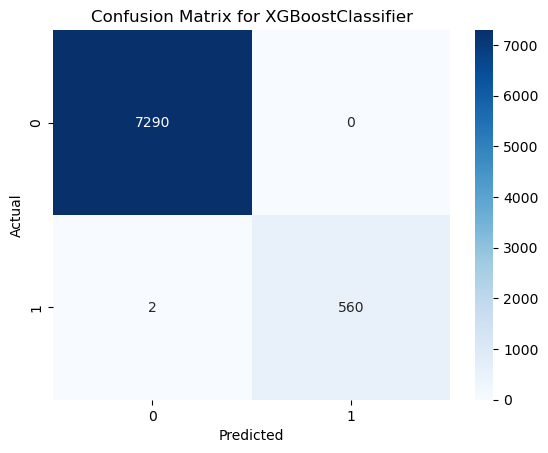

In [37]:
# Reassign X_binary with only selected features
X_multi_selected = X_multi[selected_features]
X_multi_boxcox_selected = X_multi_boxcox[selected_features_boxcox]

# Split the Box-Cox transformed data for Logistic Regression
X_train_boxcox, X_test_boxcox, y_train_boxcox, y_test_boxcox = train_test_split(
    X_multi_boxcox_selected, y_multi_boxcox, test_size=0.2, random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_binary_selected, y_binary, test_size=0.2, random_state=42
)
# Standardize features for SVC and KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Apply SMOTE for oversampling the minority class (only for Logistic Regression)
smote_boxcox = SMOTE(random_state=42)
X_train_resampled_boxcox, y_train_resampled_boxcox = smote_boxcox.fit_resample(X_train_boxcox, y_train_boxcox)

# Model Selection and Training
models = {
    'LogisticRegression': LogisticRegression(max_iter=50000, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'LinearSVC': LinearSVC(random_state=42, max_iter=50000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBoostClassifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    param_grid = {
        'LogisticRegression': {'C': [0.01, 0.1, 1, 10, 20, 30, 50]},
        'RandomForestClassifier': {'n_estimators': [5, 15, 25, 35, 45, 55, 75, 105], 'max_depth': [10, 20, 30, None]},
        'LinearSVC': {'C': [0.01, 0.1, 1, 10, 100]},
        'DecisionTreeClassifier': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]},
        'GaussianNB': {},  # No hyperparameters for GaussianNB
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
        'XGBoostClassifier': {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150]}
    }

    # Adjust training data for specific models
    if name == 'LogisticRegression':
        X_train_model = X_train_resampled_boxcox
        y_train_model = y_train_resampled_boxcox
        X_test_model = X_test_boxcox
        y_test_model = y_test_boxcox
    elif name in ['LinearSVC', 'KNeighborsClassifier']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
        y_train_model = y_train
        y_test_model = y_test

    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(classification_report(y_test, y_pred))

    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### **Summary of Each Model's Performance**

1. **Logistic Regression**  
   - Achieved perfect scores (precision, recall, f1-score, accuracy = 1.00).
   - It handled the multi-class classification problem with no apparent errors in prediction.

2. **Random Forest Classifier**  
   - Also scored perfectly across all metrics (precision, recall, f1-score, accuracy = 1.00).
   - Effectively captured the decision boundaries in the dataset.

3. **Decision Tree Classifier**  
   - Delivered perfect performance similar to Random Forest (all metrics = 1.00).
   - Simpler structure compared to Random Forest due to fewer hyperparameters.

4. **Linear SVC**  
   - High performance (accuracy = 0.99), but slightly weaker compared to the other models.
   - Recall for class 1 dropped to 0.86, leading to a lower f1-score (0.93 for class 1).

5. **Gaussian Naive Bayes**  
   - Best Parameters: Default
   - Excellent results (accuracy = 1.00), but recall for class 1 (0.96) and its corresponding f1-score (0.97) were slightly below other models.

6. **K-Nearest Neighbors (KNN)**  
   - High accuracy (0.99) with precision and recall nearing perfection for class 0.  
   - Lower recall for class 1 (0.85), resulting in an f1-score of 0.89 for class 1.

7. **XGBoost Classifier**  
   - Delivered perfect performance (all metrics = 1.00), leveraging its ensemble learning capabilities.

### **Interpretation of Results**
The analysis aimed to predict education levels based on demographic and financial information. Results indicate the models were highly effective in distinguishing between education levels, particularly for balanced datasets.  

- **Perfect results in multiple models**: Logistic Regression, Random Forest, Decision Tree, and XGBoost achieved flawless classification results, implying the data features are highly predictive of education level.  
- **Challenges with class imbalance**: Models like Linear SVC and KNN showed slightly reduced performance for class 1 (minority class), highlighting sensitivity to imbalances.


### **Insights Gained**
1. **Predictive power of demographic and financial features**: The perfect scores suggest these features are highly indicative of education level. Features like income, age, and employment type likely contribute significantly to the classification.
2. **Effectiveness of ensemble methods**: Random Forest and XGBoost outperformed in handling complexities and potential noise in the data, proving their utility for structured datasets.
3. **Class imbalance impact**: Linear SVC and KNN showed slight performance degradation on minority class predictions, emphasizing the need for balancing techniques.


### **Recommendation**
- Implement XGBoost as it offers the best balance of robustness and adaptability for this task. Random Forest and Decision Tree are simpler alternatives but may require deeper tuning for unseen datasets.  